In [1]:
import pickle
import pandas as pd
import numpy as np
import nrrd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output

from radiomics import featureextractor, getTestCase
import SimpleITK as sitk
import subprocess

import os
import glob
import shutil

import time
import datetime

print(datetime.datetime.now())

2021-09-03 04:28:16.677834


In [2]:
# INPUTS
path_meta = 'data/d20210727/nrrds_metadata/'
path_masks = 'data/d20210727/masks_training/'
path_raters = 'data/d20210727/raters/'

# TEMP PATHS
temp_unzip = 'data/d20210727/raters/temp_unzip'

# PARAMETERS
mask_liverNum = 1
mask_spleenNum = 2

In [3]:
t0 = time.time()
problems = []
times = []

listMasks = ['448', '366', '195']
listRaters = ['Rater_1', 'Rater_2', 'Rater_3', 'Rater_4', 'Rater_5']

for eaRater in listRaters:
    path_zip = path_raters + eaRater + '.zip'
    os.mkdir(temp_unzip)
    cmd = 'unzip %s -d %s' %(path_zip, temp_unzip)   # unzip WHAT -d WHERE
    subprocess.run(cmd, shell=True)
    print(eaRater + ' volumes')

    for eaPatientID in listMasks:
        t1 = time.time()
        try:
            curr_path = temp_unzip + '/' + eaRater + '/' + str(eaPatientID)
            fns_masks = [x for x in os.listdir(curr_path) if (x.endswith('.p') and not x.startswith("._"))]
            i_masks = np.array([x.replace(".p", "") for x in fns_masks], dtype = int)
            mask = np.array([pickle.load(open(os.path.join(curr_path, x), "rb")) 
                             for x in np.array(fns_masks)[np.argsort(i_masks).astype(int)]])
            mask = mask.transpose()
            
            # make liver masks
            mask_liver = mask.copy()
            mask_liver[np.where(mask_liver != mask_liverNum)] = 0
            mask_liver[np.where(mask_liver == mask_liverNum)] = 1
            
            try:
                # get metadata from other nrrd (converted from dicom)
                temp_nrrd = nrrd.read(path_meta + str(eaPatientID) + '.nrrd')
                currMeta = temp_nrrd[1]
                currMeta["type"] = "int"
                sizeBlock = np.prod(sum(currMeta['space directions']))

                # number of liver blocks
                numLiverBlocks = sum(sum(sum(mask==mask_liverNum)))
                # number of spleen blocks
                numSpleenBlocks = sum(sum(sum(mask==mask_spleenNum)))

                print(eaPatientID + ' liver: ' + str(sizeBlock*numLiverBlocks))        
                print(eaPatientID + ' spleen: ' + str(sizeBlock*numSpleenBlocks))        
                times.append(time.time() - t1)
                
                # write nrrds for spleen and liver masks
                path_liverMask = path_raters + 'liverMask_pid' + str(eaPatientID) + '_ra' + str(eaRater) + '.nrrd'
                nrrd.write(path_liverMask, mask_liver, header=currMeta)

            except:
                print(eaPatientID + ': problem with nrrd meta file')
                problems.append(eaRater + '_' + eaPatientID)
            
        except:
            print(eaPatientID + ': problem with mask files')
            problems.append(eaRater + '_' + eaPatientID)


        
    # remove temp_unzip files
    shutil.rmtree(temp_unzip)

timeElapsed = time.time() - t0
print(timeElapsed)
print(datetime.datetime.now())


Rater_1 volumes
448 liver: 1334201.2505187988
448 spleen: 401739.49614715576
366 liver: 964716.1430358887
366 spleen: 805608.7471008301
195 liver: 894301.2326965332
195 spleen: 112099.30288696289
Rater_2 volumes
448 liver: 1379066.0709228516
448 spleen: 411750.33170318604
366 liver: 959470.8442687988
366 spleen: 787422.5379943848
195 liver: 915525.3770446777
195 spleen: 114538.10958862305
Rater_3 volumes
448 liver: 1351335.3782196045
448 spleen: 406493.1530227661
366 liver: 854484.4451904297
366 spleen: 702434.4932556152
195 liver: 890906.4814453125
195 spleen: 110788.05151367188
Rater_4 volumes
448 liver: 1316795.837600708
448 spleen: 397013.58435058594
366 liver: 923686.4593505859
366 spleen: 789907.3181152344
195 liver: 925743.469543457
195 spleen: 115982.29888916016
Rater_5 volumes
448 liver: 1338315.742980957
448 spleen: 406621.60246276855
366 liver: 665433.3076477051
366 spleen: 566119.393157959
195 liver: 908621.0645141602
195 spleen: 114434.17630004883
416.1207091808319
2021-09

Text(0.5, 0, 'Seconds')

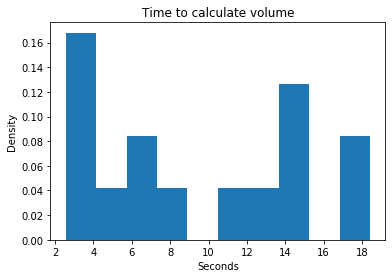

In [4]:
plt.hist(times, density=True)
plt.title('Time to calculate volume')
plt.ylabel('Density')
plt.xlabel('Seconds')

In [5]:
print('Time per scan: ')
print(str(timeElapsed / (len(listMasks) - len(problems))))

Time per scan: 
138.7069030602773


In [6]:
times

[4.868956565856934,
 18.422707319259644,
 14.724293231964111,
 2.8175528049468994,
 14.543548345565796,
 18.4050350189209,
 2.562317371368408,
 7.133849382400513,
 14.093777894973755,
 2.5511322021484375,
 8.05488133430481,
 13.151850938796997,
 2.5769975185394287,
 5.826488018035889,
 11.61182975769043]

In [7]:
print('Problems:')
print(problems)

Problems:
[]


In [8]:
print(datetime.datetime.now())

2021-09-03 04:35:13.140019
